In [ ]:
def generate_mutation(samples, labels, test_transform, net, img_shape=(32,32), batch_num=256):
    mutated_samples = []
    ground_truth = []
    dataset_train = UserDataset(samples ,img_shape, labels = labels, transform = test_transform)
    dataloader  = DataLoader(dataset_train, batch_size=batch_num, num_workers=4, pin_memory=True)
    acc, c_conf, w_conf, right_index, wrong_index = test( net, dataloader )
    print("[Initial] Acc: {}({}/{})\tC_conf:{}\tW_conf:{}".format(acc,len(right_index),len(samples),c_conf, w_conf))
    
    mutated_samples.append(samples[wrong_index])
    ground_truth.append(labels[wrong_index])
    count = len(wrong_index)
    total = len(samples)
    samples, labels = samples[right_index], labels[right_index]
    print("Start mutation process...")
    print(">>>: Add {} natural adversarial examples({}/{})".format(count, count, total))
    iteration = 0
    mutation_time=3
    while count < total and iteration < 10000:
        if iteration > 5000:
            mutation_time=4
        cur_mutated = []
        for sample in samples:
            # "translation":0,"scale":1,"shear":2,"rotation":3,"pixel_change":4,"noise":5,"contrast":6,"brightness":7,"blur":8
            mutation = Mutators.mutate(sample, mutation_name=None, mutation_time=mutation_time ,mutation_type=0)
            cur_mutated.append(mutation)
        cur_mutated = np.array(cur_mutated)
        
        dataset_train = UserDataset(cur_mutated, img_shape, labels, test_transform)
        dataloader  = DataLoader(dataset_train, batch_num, num_workers=4, )
        acc, c_conf, w_conf, right_index, wrong_index = test( net, dataloader )
        if len(wrong_index) == 0:
            print("Iteration {}: No update({}/{})".format(iteration,count,total))
            if len(right_index) == 0:
                print("Iteration {}:Finished!".format(iteration))
        else:
            mutated_samples.append(cur_mutated[wrong_index])
            ground_truth.append(labels[wrong_index])
            new_add = len(wrong_index)
            count += new_add
            print("Iteration {}: Add {} new mutations({}/{})".format(iteration,new_add, count, total))
            if len(right_index) == 0:
                print("Iteration {}:Finished !".format(iteration))
            else:
                samples, labels = samples[right_index], labels[right_index]
        iteration += 1
    return np.concatenate(mutated_samples,axis=0),np.concatenate(ground_truth,axis=0)

def mtest(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    right_conf = 0.0
    wrong_conf = 0.0
    right_index = []
    wrong_index = []
    to_np = lambda x: x.data.cpu().numpy()
    offset = 0
    with torch.no_grad():
        for (inputs, labels) in dataloader:
            total += labels.size(0)
            inputs = inputs.cuda()
            labels = labels.cuda()
            scores, _ = model(inputs)
            msps, preds = torch.max(torch.softmax(scores.data,1),1)
            correct += (preds == labels).sum().item()
            right_conf += msps[preds == labels].sum().item()
            wrong_conf += msps[preds != labels].sum().item()
            preds = to_np(preds)
            labels = to_np(labels)
            right_index.append(np.where(labels==preds)[0]+offset)
            wrong_index.append(np.where(labels!=preds)[0]+offset)
            offset += len(labels)
            
    wrong = total - correct
    
    acc = np.round(100 * correct / total, 2)
    c_conf = np.round((100 * right_conf) / correct , 2) if correct != 0 else -1
    w_conf = np.round((100 * wrong_conf) / wrong , 2) if wrong != 0 else -1
    right_index = np.concatenate(right_index,axis=0)
    wrong_index = np.concatenate(wrong_index,axis=0)
    return acc, c_conf, w_conf, right_index, wrong_index



In [1]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import torchvision.transforms as T
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader
from data.UserDataset import UserDataset
from keras.datasets import cifar10
from models.resnet import ResNet18
import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as  sns
import joblib
import pandas as pd
from mutators import Mutators
from generate_utils import generate_mutation,mtest

Using TensorFlow backend.


# Mutation Generation

In [2]:
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.247, 0.2435, 0.2616]
test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(cifar10_mean, cifar10_std) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
        ])
(_,_),(x_train,y_train) = cifar10.load_data()
model_weights = {
    "resnet18_LLAL":"./cifar10/train/weights/active_resnet18_cifar10_LLAL_1.pth",
    "resnet18_Entropy":"./cifar10/train/weights/active_resnet18_cifar10_Entropy_1.pth",
}

model_name = "resnet18_LLAL"
net = ResNet18(num_classes=10).cuda()
net.load_state_dict(torch.load(model_weights[model_name])['state_dict_backbone'])
net.eval()
mutated_samples,ground_truth = generate_mutation(x_train,np.int64(y_train.squeeze()), test_transform, net)

[Initial] Acc: 90.14(9014/10000)	C_conf:97.86	W_conf:81.5
Start mutation process...
>>> Add 986 natural adversarial examples(986/10000)
Iteration 0: Add 1861 new mutations(2847/10000,m:3)
Iteration 1: Add 1211 new mutations(4058/10000,m:3)
Iteration 2: Add 851 new mutations(4909/10000,m:3)
Iteration 3: Add 659 new mutations(5568/10000,m:3)
Iteration 4: Add 487 new mutations(6055/10000,m:3)
Iteration 5: Add 419 new mutations(6474/10000,m:3)
Iteration 6: Add 330 new mutations(6804/10000,m:3)
Iteration 7: Add 284 new mutations(7088/10000,m:3)
Iteration 8: Add 228 new mutations(7316/10000,m:3)
Iteration 9: Add 201 new mutations(7517/10000,m:3)
Iteration 10: Add 162 new mutations(7679/10000,m:3)
Iteration 11: Add 140 new mutations(7819/10000,m:3)
Iteration 12: Add 128 new mutations(7947/10000,m:3)
Iteration 13: Add 122 new mutations(8069/10000,m:3)
Iteration 14: Add 114 new mutations(8183/10000,m:3)
Iteration 15: Add 92 new mutations(8275/10000,m:3)
Iteration 16: Add 91 new mutations(8366/1

Iteration 162: No update(9817/10000,m:3)
Iteration 163: No update(9817/10000,m:3)
Iteration 164: No update(9817/10000,m:3)
Iteration 165: Add 1 new mutations(9818/10000,m:3)
Iteration 166: No update(9818/10000,m:3)
Iteration 167: Add 1 new mutations(9819/10000,m:3)
Iteration 168: Add 2 new mutations(9821/10000,m:3)
Iteration 169: Add 1 new mutations(9822/10000,m:3)
Iteration 170: Add 1 new mutations(9823/10000,m:3)
Iteration 171: Add 2 new mutations(9825/10000,m:3)
Iteration 172: Add 1 new mutations(9826/10000,m:3)
Iteration 173: No update(9826/10000,m:3)
Iteration 174: Add 2 new mutations(9828/10000,m:3)
Iteration 175: Add 1 new mutations(9829/10000,m:3)
Iteration 176: No update(9829/10000,m:3)
Iteration 177: Add 1 new mutations(9830/10000,m:3)
Iteration 178: Add 1 new mutations(9831/10000,m:3)
Iteration 179: No update(9831/10000,m:3)
Iteration 180: Add 2 new mutations(9833/10000,m:3)
Iteration 181: Add 1 new mutations(9834/10000,m:3)
Iteration 182: Add 1 new mutations(9835/10000,m:3)

Iteration 345: No update(9912/10000,m:3)
Iteration 346: No update(9912/10000,m:3)
Iteration 347: Add 1 new mutations(9913/10000,m:3)
Iteration 348: No update(9913/10000,m:3)
Iteration 349: Add 1 new mutations(9914/10000,m:3)
Iteration 350: No update(9914/10000,m:3)
Iteration 351: No update(9914/10000,m:3)
Iteration 352: No update(9914/10000,m:3)
Iteration 353: No update(9914/10000,m:3)
Iteration 354: Add 1 new mutations(9915/10000,m:3)
Iteration 355: No update(9915/10000,m:3)
Iteration 356: No update(9915/10000,m:3)
Iteration 357: No update(9915/10000,m:3)
Iteration 358: No update(9915/10000,m:3)
Iteration 359: No update(9915/10000,m:3)
Iteration 360: Add 1 new mutations(9916/10000,m:3)
Iteration 361: No update(9916/10000,m:3)
Iteration 362: Add 1 new mutations(9917/10000,m:3)
Iteration 363: No update(9917/10000,m:3)
Iteration 364: No update(9917/10000,m:3)
Iteration 365: Add 1 new mutations(9918/10000,m:3)
Iteration 366: Add 1 new mutations(9919/10000,m:3)
Iteration 367: No update(991

Iteration 537: No update(9950/10000,m:3)
Iteration 538: No update(9950/10000,m:3)
Iteration 539: No update(9950/10000,m:3)
Iteration 540: No update(9950/10000,m:3)
Iteration 541: No update(9950/10000,m:3)
Iteration 542: No update(9950/10000,m:3)
Iteration 543: No update(9950/10000,m:3)
Iteration 544: No update(9950/10000,m:3)
Iteration 545: No update(9950/10000,m:3)
Iteration 546: No update(9950/10000,m:3)
Iteration 547: No update(9950/10000,m:3)
Iteration 548: No update(9950/10000,m:3)
Iteration 549: No update(9950/10000,m:3)
Iteration 550: No update(9950/10000,m:3)
Iteration 551: No update(9950/10000,m:3)
Iteration 552: No update(9950/10000,m:3)
Iteration 553: No update(9950/10000,m:3)
Iteration 554: No update(9950/10000,m:3)
Iteration 555: No update(9950/10000,m:3)
Iteration 556: No update(9950/10000,m:3)
Iteration 557: No update(9950/10000,m:3)
Iteration 558: No update(9950/10000,m:3)
Iteration 559: No update(9950/10000,m:3)
Iteration 560: No update(9950/10000,m:3)
Iteration 561: N

Iteration 735: No update(9960/10000,m:3)
Iteration 736: No update(9960/10000,m:3)
Iteration 737: No update(9960/10000,m:3)
Iteration 738: No update(9960/10000,m:3)
Iteration 739: No update(9960/10000,m:3)
Iteration 740: No update(9960/10000,m:3)
Iteration 741: No update(9960/10000,m:3)
Iteration 742: No update(9960/10000,m:3)
Iteration 743: Add 1 new mutations(9961/10000,m:3)
Iteration 744: No update(9961/10000,m:3)
Iteration 745: No update(9961/10000,m:3)
Iteration 746: No update(9961/10000,m:3)
Iteration 747: No update(9961/10000,m:3)
Iteration 748: No update(9961/10000,m:3)
Iteration 749: No update(9961/10000,m:3)
Iteration 750: Add 1 new mutations(9962/10000,m:3)
Iteration 751: No update(9962/10000,m:3)
Iteration 752: No update(9962/10000,m:3)
Iteration 753: No update(9962/10000,m:3)
Iteration 754: No update(9962/10000,m:3)
Iteration 755: No update(9962/10000,m:3)
Iteration 756: No update(9962/10000,m:3)
Iteration 757: No update(9962/10000,m:3)
Iteration 758: No update(9962/10000,m

Iteration 933: No update(9971/10000,m:3)
Iteration 934: No update(9971/10000,m:3)
Iteration 935: No update(9971/10000,m:3)
Iteration 936: No update(9971/10000,m:3)
Iteration 937: Add 1 new mutations(9972/10000,m:3)
Iteration 938: No update(9972/10000,m:3)
Iteration 939: No update(9972/10000,m:3)
Iteration 940: No update(9972/10000,m:3)
Iteration 941: No update(9972/10000,m:3)
Iteration 942: No update(9972/10000,m:3)
Iteration 943: No update(9972/10000,m:3)
Iteration 944: No update(9972/10000,m:3)
Iteration 945: No update(9972/10000,m:3)
Iteration 946: No update(9972/10000,m:3)
Iteration 947: No update(9972/10000,m:3)
Iteration 948: No update(9972/10000,m:3)
Iteration 949: No update(9972/10000,m:3)
Iteration 950: No update(9972/10000,m:3)
Iteration 951: No update(9972/10000,m:3)
Iteration 952: No update(9972/10000,m:3)
Iteration 953: No update(9972/10000,m:3)
Iteration 954: No update(9972/10000,m:3)
Iteration 955: No update(9972/10000,m:3)
Iteration 956: Add 1 new mutations(9973/10000,m

Iteration 1129: No update(9977/10000,m:3)
Iteration 1130: No update(9977/10000,m:3)
Iteration 1131: No update(9977/10000,m:3)
Iteration 1132: No update(9977/10000,m:3)
Iteration 1133: No update(9977/10000,m:3)
Iteration 1134: No update(9977/10000,m:3)
Iteration 1135: No update(9977/10000,m:3)
Iteration 1136: No update(9977/10000,m:3)
Iteration 1137: No update(9977/10000,m:3)
Iteration 1138: No update(9977/10000,m:3)
Iteration 1139: No update(9977/10000,m:3)
Iteration 1140: No update(9977/10000,m:3)
Iteration 1141: No update(9977/10000,m:3)
Iteration 1142: No update(9977/10000,m:3)
Iteration 1143: No update(9977/10000,m:3)
Iteration 1144: No update(9977/10000,m:3)
Iteration 1145: No update(9977/10000,m:3)
Iteration 1146: No update(9977/10000,m:3)
Iteration 1147: No update(9977/10000,m:3)
Iteration 1148: No update(9977/10000,m:3)
Iteration 1149: No update(9977/10000,m:3)
Iteration 1150: No update(9977/10000,m:3)
Iteration 1151: No update(9977/10000,m:3)
Iteration 1152: No update(9977/100

Iteration 1324: No update(9980/10000,m:3)
Iteration 1325: No update(9980/10000,m:3)
Iteration 1326: No update(9980/10000,m:3)
Iteration 1327: No update(9980/10000,m:3)
Iteration 1328: No update(9980/10000,m:3)
Iteration 1329: No update(9980/10000,m:3)
Iteration 1330: No update(9980/10000,m:3)
Iteration 1331: No update(9980/10000,m:3)
Iteration 1332: No update(9980/10000,m:3)
Iteration 1333: No update(9980/10000,m:3)
Iteration 1334: No update(9980/10000,m:3)
Iteration 1335: No update(9980/10000,m:3)
Iteration 1336: No update(9980/10000,m:3)
Iteration 1337: No update(9980/10000,m:3)
Iteration 1338: No update(9980/10000,m:3)
Iteration 1339: No update(9980/10000,m:3)
Iteration 1340: No update(9980/10000,m:3)
Iteration 1341: No update(9980/10000,m:3)
Iteration 1342: No update(9980/10000,m:3)
Iteration 1343: No update(9980/10000,m:3)
Iteration 1344: No update(9980/10000,m:3)
Iteration 1345: No update(9980/10000,m:3)
Iteration 1346: No update(9980/10000,m:3)
Iteration 1347: No update(9980/100

Iteration 1519: No update(9984/10000,m:3)
Iteration 1520: No update(9984/10000,m:3)
Iteration 1521: No update(9984/10000,m:3)
Iteration 1522: No update(9984/10000,m:3)
Iteration 1523: No update(9984/10000,m:3)
Iteration 1524: No update(9984/10000,m:3)
Iteration 1525: No update(9984/10000,m:3)
Iteration 1526: No update(9984/10000,m:3)
Iteration 1527: No update(9984/10000,m:3)
Iteration 1528: No update(9984/10000,m:3)
Iteration 1529: No update(9984/10000,m:3)
Iteration 1530: No update(9984/10000,m:3)
Iteration 1531: No update(9984/10000,m:3)
Iteration 1532: No update(9984/10000,m:3)
Iteration 1533: No update(9984/10000,m:3)
Iteration 1534: No update(9984/10000,m:3)
Iteration 1535: No update(9984/10000,m:3)
Iteration 1536: No update(9984/10000,m:3)
Iteration 1537: No update(9984/10000,m:3)
Iteration 1538: No update(9984/10000,m:3)
Iteration 1539: No update(9984/10000,m:3)
Iteration 1540: No update(9984/10000,m:3)
Iteration 1541: No update(9984/10000,m:3)
Iteration 1542: No update(9984/100

Iteration 1715: No update(9984/10000,m:3)
Iteration 1716: No update(9984/10000,m:3)
Iteration 1717: No update(9984/10000,m:3)
Iteration 1718: No update(9984/10000,m:3)
Iteration 1719: No update(9984/10000,m:3)
Iteration 1720: No update(9984/10000,m:3)
Iteration 1721: No update(9984/10000,m:3)
Iteration 1722: No update(9984/10000,m:3)
Iteration 1723: No update(9984/10000,m:3)
Iteration 1724: No update(9984/10000,m:3)
Iteration 1725: No update(9984/10000,m:3)
Iteration 1726: No update(9984/10000,m:3)
Iteration 1727: No update(9984/10000,m:3)
Iteration 1728: No update(9984/10000,m:3)
Iteration 1729: Add 1 new mutations(9985/10000,m:3)
Iteration 1730: No update(9985/10000,m:3)
Iteration 1731: No update(9985/10000,m:3)
Iteration 1732: No update(9985/10000,m:3)
Iteration 1733: No update(9985/10000,m:3)
Iteration 1734: No update(9985/10000,m:3)
Iteration 1735: No update(9985/10000,m:3)
Iteration 1736: No update(9985/10000,m:3)
Iteration 1737: No update(9985/10000,m:3)
Iteration 1738: No updat

Iteration 1910: No update(9988/10000,m:3)
Iteration 1911: No update(9988/10000,m:3)
Iteration 1912: No update(9988/10000,m:3)
Iteration 1913: No update(9988/10000,m:3)
Iteration 1914: No update(9988/10000,m:3)
Iteration 1915: No update(9988/10000,m:3)
Iteration 1916: No update(9988/10000,m:3)
Iteration 1917: No update(9988/10000,m:3)
Iteration 1918: No update(9988/10000,m:3)
Iteration 1919: No update(9988/10000,m:3)
Iteration 1920: No update(9988/10000,m:3)
Iteration 1921: No update(9988/10000,m:3)
Iteration 1922: No update(9988/10000,m:3)
Iteration 1923: No update(9988/10000,m:3)
Iteration 1924: No update(9988/10000,m:3)
Iteration 1925: No update(9988/10000,m:3)
Iteration 1926: No update(9988/10000,m:3)
Iteration 1927: No update(9988/10000,m:3)
Iteration 1928: No update(9988/10000,m:3)
Iteration 1929: No update(9988/10000,m:3)
Iteration 1930: No update(9988/10000,m:3)
Iteration 1931: No update(9988/10000,m:3)
Iteration 1932: No update(9988/10000,m:3)
Iteration 1933: No update(9988/100

Iteration 2105: No update(9992/10000,m:4)
Iteration 2106: No update(9992/10000,m:4)
Iteration 2107: No update(9992/10000,m:4)
Iteration 2108: No update(9992/10000,m:4)
Iteration 2109: No update(9992/10000,m:4)
Iteration 2110: No update(9992/10000,m:4)
Iteration 2111: No update(9992/10000,m:4)
Iteration 2112: No update(9992/10000,m:4)
Iteration 2113: No update(9992/10000,m:4)
Iteration 2114: No update(9992/10000,m:4)
Iteration 2115: No update(9992/10000,m:4)
Iteration 2116: No update(9992/10000,m:4)
Iteration 2117: No update(9992/10000,m:4)
Iteration 2118: No update(9992/10000,m:4)
Iteration 2119: No update(9992/10000,m:4)
Iteration 2120: No update(9992/10000,m:4)
Iteration 2121: No update(9992/10000,m:4)
Iteration 2122: No update(9992/10000,m:4)
Iteration 2123: No update(9992/10000,m:4)
Iteration 2124: No update(9992/10000,m:4)
Iteration 2125: No update(9992/10000,m:4)
Iteration 2126: No update(9992/10000,m:4)
Iteration 2127: No update(9992/10000,m:4)
Iteration 2128: No update(9992/100

Iteration 2300: No update(9994/10000,m:4)
Iteration 2301: No update(9994/10000,m:4)
Iteration 2302: No update(9994/10000,m:4)
Iteration 2303: No update(9994/10000,m:4)
Iteration 2304: No update(9994/10000,m:4)
Iteration 2305: No update(9994/10000,m:4)
Iteration 2306: No update(9994/10000,m:4)
Iteration 2307: No update(9994/10000,m:4)
Iteration 2308: No update(9994/10000,m:4)
Iteration 2309: No update(9994/10000,m:4)
Iteration 2310: No update(9994/10000,m:4)
Iteration 2311: No update(9994/10000,m:4)
Iteration 2312: No update(9994/10000,m:4)
Iteration 2313: No update(9994/10000,m:4)
Iteration 2314: No update(9994/10000,m:4)
Iteration 2315: No update(9994/10000,m:4)
Iteration 2316: No update(9994/10000,m:4)
Iteration 2317: No update(9994/10000,m:4)
Iteration 2318: No update(9994/10000,m:4)
Iteration 2319: No update(9994/10000,m:4)
Iteration 2320: No update(9994/10000,m:4)
Iteration 2321: No update(9994/10000,m:4)
Iteration 2322: No update(9994/10000,m:4)
Iteration 2323: No update(9994/100

Iteration 2495: No update(9995/10000,m:4)
Iteration 2496: No update(9995/10000,m:4)
Iteration 2497: No update(9995/10000,m:4)
Iteration 2498: No update(9995/10000,m:4)
Iteration 2499: No update(9995/10000,m:4)
Iteration 2500: No update(9995/10000,m:4)
Iteration 2501: No update(9995/10000,m:4)
Iteration 2502: No update(9995/10000,m:4)
Iteration 2503: No update(9995/10000,m:4)
Iteration 2504: No update(9995/10000,m:4)
Iteration 2505: No update(9995/10000,m:4)
Iteration 2506: No update(9995/10000,m:4)
Iteration 2507: No update(9995/10000,m:4)
Iteration 2508: No update(9995/10000,m:4)
Iteration 2509: No update(9995/10000,m:4)
Iteration 2510: No update(9995/10000,m:4)
Iteration 2511: No update(9995/10000,m:4)
Iteration 2512: No update(9995/10000,m:4)
Iteration 2513: No update(9995/10000,m:4)
Iteration 2514: No update(9995/10000,m:4)
Iteration 2515: No update(9995/10000,m:4)
Iteration 2516: No update(9995/10000,m:4)
Iteration 2517: No update(9995/10000,m:4)
Iteration 2518: No update(9995/100

Iteration 2691: No update(9995/10000,m:4)
Iteration 2692: No update(9995/10000,m:4)
Iteration 2693: No update(9995/10000,m:4)
Iteration 2694: No update(9995/10000,m:4)
Iteration 2695: No update(9995/10000,m:4)
Iteration 2696: No update(9995/10000,m:4)
Iteration 2697: No update(9995/10000,m:4)
Iteration 2698: No update(9995/10000,m:4)
Iteration 2699: No update(9995/10000,m:4)
Iteration 2700: No update(9995/10000,m:4)
Iteration 2701: No update(9995/10000,m:4)
Iteration 2702: No update(9995/10000,m:4)
Iteration 2703: No update(9995/10000,m:4)
Iteration 2704: No update(9995/10000,m:4)
Iteration 2705: No update(9995/10000,m:4)
Iteration 2706: No update(9995/10000,m:4)
Iteration 2707: No update(9995/10000,m:4)
Iteration 2708: No update(9995/10000,m:4)
Iteration 2709: No update(9995/10000,m:4)
Iteration 2710: No update(9995/10000,m:4)
Iteration 2711: No update(9995/10000,m:4)
Iteration 2712: No update(9995/10000,m:4)
Iteration 2713: No update(9995/10000,m:4)
Iteration 2714: No update(9995/100

Iteration 2887: No update(9995/10000,m:4)
Iteration 2888: No update(9995/10000,m:4)
Iteration 2889: No update(9995/10000,m:4)
Iteration 2890: No update(9995/10000,m:4)
Iteration 2891: No update(9995/10000,m:4)
Iteration 2892: No update(9995/10000,m:4)
Iteration 2893: No update(9995/10000,m:4)
Iteration 2894: No update(9995/10000,m:4)
Iteration 2895: No update(9995/10000,m:4)
Iteration 2896: No update(9995/10000,m:4)
Iteration 2897: No update(9995/10000,m:4)
Iteration 2898: No update(9995/10000,m:4)
Iteration 2899: No update(9995/10000,m:4)
Iteration 2900: No update(9995/10000,m:4)
Iteration 2901: No update(9995/10000,m:4)
Iteration 2902: No update(9995/10000,m:4)
Iteration 2903: No update(9995/10000,m:4)
Iteration 2904: No update(9995/10000,m:4)
Iteration 2905: No update(9995/10000,m:4)
Iteration 2906: No update(9995/10000,m:4)
Iteration 2907: No update(9995/10000,m:4)
Iteration 2908: No update(9995/10000,m:4)
Iteration 2909: No update(9995/10000,m:4)
Iteration 2910: No update(9995/100

Iteration 3083: No update(9995/10000,m:4)
Iteration 3084: No update(9995/10000,m:4)
Iteration 3085: No update(9995/10000,m:4)
Iteration 3086: No update(9995/10000,m:4)
Iteration 3087: No update(9995/10000,m:4)
Iteration 3088: No update(9995/10000,m:4)
Iteration 3089: No update(9995/10000,m:4)
Iteration 3090: No update(9995/10000,m:4)
Iteration 3091: No update(9995/10000,m:4)
Iteration 3092: No update(9995/10000,m:4)
Iteration 3093: No update(9995/10000,m:4)
Iteration 3094: No update(9995/10000,m:4)
Iteration 3095: No update(9995/10000,m:4)
Iteration 3096: No update(9995/10000,m:4)
Iteration 3097: No update(9995/10000,m:4)
Iteration 3098: No update(9995/10000,m:4)
Iteration 3099: No update(9995/10000,m:4)
Iteration 3100: No update(9995/10000,m:4)
Iteration 3101: No update(9995/10000,m:4)
Iteration 3102: No update(9995/10000,m:4)
Iteration 3103: No update(9995/10000,m:4)
Iteration 3104: No update(9995/10000,m:4)
Iteration 3105: No update(9995/10000,m:4)
Iteration 3106: No update(9995/100

Iteration 3278: No update(9996/10000,m:4)
Iteration 3279: No update(9996/10000,m:4)
Iteration 3280: No update(9996/10000,m:4)
Iteration 3281: No update(9996/10000,m:4)
Iteration 3282: No update(9996/10000,m:4)
Iteration 3283: No update(9996/10000,m:4)
Iteration 3284: No update(9996/10000,m:4)
Iteration 3285: No update(9996/10000,m:4)
Iteration 3286: No update(9996/10000,m:4)
Iteration 3287: No update(9996/10000,m:4)
Iteration 3288: No update(9996/10000,m:4)
Iteration 3289: No update(9996/10000,m:4)
Iteration 3290: No update(9996/10000,m:4)
Iteration 3291: No update(9996/10000,m:4)
Iteration 3292: No update(9996/10000,m:4)
Iteration 3293: No update(9996/10000,m:4)
Iteration 3294: No update(9996/10000,m:4)
Iteration 3295: No update(9996/10000,m:4)
Iteration 3296: No update(9996/10000,m:4)
Iteration 3297: No update(9996/10000,m:4)
Iteration 3298: No update(9996/10000,m:4)
Iteration 3299: No update(9996/10000,m:4)
Iteration 3300: No update(9996/10000,m:4)
Iteration 3301: No update(9996/100

Iteration 3474: No update(9996/10000,m:4)
Iteration 3475: No update(9996/10000,m:4)
Iteration 3476: No update(9996/10000,m:4)
Iteration 3477: No update(9996/10000,m:4)
Iteration 3478: No update(9996/10000,m:4)
Iteration 3479: No update(9996/10000,m:4)
Iteration 3480: No update(9996/10000,m:4)
Iteration 3481: No update(9996/10000,m:4)
Iteration 3482: No update(9996/10000,m:4)
Iteration 3483: No update(9996/10000,m:4)
Iteration 3484: No update(9996/10000,m:4)
Iteration 3485: No update(9996/10000,m:4)
Iteration 3486: No update(9996/10000,m:4)
Iteration 3487: No update(9996/10000,m:4)
Iteration 3488: No update(9996/10000,m:4)
Iteration 3489: Add 1 new mutations(9997/10000,m:4)
Iteration 3490: No update(9997/10000,m:4)
Iteration 3491: No update(9997/10000,m:4)
Iteration 3492: No update(9997/10000,m:4)
Iteration 3493: No update(9997/10000,m:4)
Iteration 3494: No update(9997/10000,m:4)
Iteration 3495: No update(9997/10000,m:4)
Iteration 3496: No update(9997/10000,m:4)
Iteration 3497: No updat

Iteration 3669: No update(9998/10000,m:4)
Iteration 3670: No update(9998/10000,m:4)
Iteration 3671: No update(9998/10000,m:4)
Iteration 3672: No update(9998/10000,m:4)
Iteration 3673: No update(9998/10000,m:4)
Iteration 3674: No update(9998/10000,m:4)
Iteration 3675: No update(9998/10000,m:4)
Iteration 3676: No update(9998/10000,m:4)
Iteration 3677: No update(9998/10000,m:4)
Iteration 3678: No update(9998/10000,m:4)
Iteration 3679: No update(9998/10000,m:4)
Iteration 3680: No update(9998/10000,m:4)
Iteration 3681: No update(9998/10000,m:4)
Iteration 3682: No update(9998/10000,m:4)
Iteration 3683: No update(9998/10000,m:4)
Iteration 3684: No update(9998/10000,m:4)
Iteration 3685: No update(9998/10000,m:4)
Iteration 3686: No update(9998/10000,m:4)
Iteration 3687: No update(9998/10000,m:4)
Iteration 3688: No update(9998/10000,m:4)
Iteration 3689: No update(9998/10000,m:4)
Iteration 3690: No update(9998/10000,m:4)
Iteration 3691: No update(9998/10000,m:4)
Iteration 3692: No update(9998/100

Iteration 3865: No update(9998/10000,m:4)
Iteration 3866: No update(9998/10000,m:4)
Iteration 3867: No update(9998/10000,m:4)
Iteration 3868: No update(9998/10000,m:4)
Iteration 3869: No update(9998/10000,m:4)
Iteration 3870: No update(9998/10000,m:4)
Iteration 3871: No update(9998/10000,m:4)
Iteration 3872: No update(9998/10000,m:4)
Iteration 3873: No update(9998/10000,m:4)
Iteration 3874: No update(9998/10000,m:4)
Iteration 3875: No update(9998/10000,m:4)
Iteration 3876: No update(9998/10000,m:4)
Iteration 3877: No update(9998/10000,m:4)
Iteration 3878: No update(9998/10000,m:4)
Iteration 3879: No update(9998/10000,m:4)
Iteration 3880: No update(9998/10000,m:4)
Iteration 3881: No update(9998/10000,m:4)
Iteration 3882: No update(9998/10000,m:4)
Iteration 3883: No update(9998/10000,m:4)
Iteration 3884: No update(9998/10000,m:4)
Iteration 3885: No update(9998/10000,m:4)
Iteration 3886: No update(9998/10000,m:4)
Iteration 3887: No update(9998/10000,m:4)
Iteration 3888: No update(9998/100

Iteration 4061: No update(9998/10000,m:4)
Iteration 4062: No update(9998/10000,m:4)
Iteration 4063: No update(9998/10000,m:4)
Iteration 4064: No update(9998/10000,m:4)
Iteration 4065: No update(9998/10000,m:4)
Iteration 4066: No update(9998/10000,m:4)
Iteration 4067: No update(9998/10000,m:4)
Iteration 4068: No update(9998/10000,m:4)
Iteration 4069: No update(9998/10000,m:4)
Iteration 4070: No update(9998/10000,m:4)
Iteration 4071: No update(9998/10000,m:4)
Iteration 4072: No update(9998/10000,m:4)
Iteration 4073: No update(9998/10000,m:4)
Iteration 4074: No update(9998/10000,m:4)
Iteration 4075: No update(9998/10000,m:4)
Iteration 4076: No update(9998/10000,m:4)
Iteration 4077: No update(9998/10000,m:4)
Iteration 4078: No update(9998/10000,m:4)
Iteration 4079: No update(9998/10000,m:4)
Iteration 4080: No update(9998/10000,m:4)
Iteration 4081: No update(9998/10000,m:4)
Iteration 4082: No update(9998/10000,m:4)
Iteration 4083: No update(9998/10000,m:4)
Iteration 4084: No update(9998/100

Iteration 4257: No update(9998/10000,m:4)
Iteration 4258: No update(9998/10000,m:4)
Iteration 4259: No update(9998/10000,m:4)
Iteration 4260: No update(9998/10000,m:4)
Iteration 4261: No update(9998/10000,m:4)
Iteration 4262: No update(9998/10000,m:4)
Iteration 4263: No update(9998/10000,m:4)
Iteration 4264: No update(9998/10000,m:4)
Iteration 4265: No update(9998/10000,m:4)
Iteration 4266: No update(9998/10000,m:4)
Iteration 4267: No update(9998/10000,m:4)
Iteration 4268: No update(9998/10000,m:4)
Iteration 4269: No update(9998/10000,m:4)
Iteration 4270: No update(9998/10000,m:4)
Iteration 4271: No update(9998/10000,m:4)
Iteration 4272: No update(9998/10000,m:4)
Iteration 4273: No update(9998/10000,m:4)
Iteration 4274: No update(9998/10000,m:4)
Iteration 4275: No update(9998/10000,m:4)
Iteration 4276: No update(9998/10000,m:4)
Iteration 4277: No update(9998/10000,m:4)
Iteration 4278: No update(9998/10000,m:4)
Iteration 4279: No update(9998/10000,m:4)
Iteration 4280: No update(9998/100

Iteration 4453: No update(9998/10000,m:4)
Iteration 4454: No update(9998/10000,m:4)
Iteration 4455: No update(9998/10000,m:4)
Iteration 4456: No update(9998/10000,m:4)
Iteration 4457: No update(9998/10000,m:4)
Iteration 4458: No update(9998/10000,m:4)
Iteration 4459: No update(9998/10000,m:4)
Iteration 4460: No update(9998/10000,m:4)
Iteration 4461: No update(9998/10000,m:4)
Iteration 4462: No update(9998/10000,m:4)
Iteration 4463: No update(9998/10000,m:4)
Iteration 4464: No update(9998/10000,m:4)
Iteration 4465: No update(9998/10000,m:4)
Iteration 4466: No update(9998/10000,m:4)
Iteration 4467: No update(9998/10000,m:4)
Iteration 4468: No update(9998/10000,m:4)
Iteration 4469: No update(9998/10000,m:4)
Iteration 4470: No update(9998/10000,m:4)
Iteration 4471: No update(9998/10000,m:4)
Iteration 4472: No update(9998/10000,m:4)
Iteration 4473: No update(9998/10000,m:4)
Iteration 4474: No update(9998/10000,m:4)
Iteration 4475: No update(9998/10000,m:4)
Iteration 4476: No update(9998/100

Iteration 4648: No update(9999/10000,m:4)
Iteration 4649: No update(9999/10000,m:4)
Iteration 4650: No update(9999/10000,m:4)
Iteration 4651: No update(9999/10000,m:4)
Iteration 4652: No update(9999/10000,m:4)
Iteration 4653: No update(9999/10000,m:4)
Iteration 4654: No update(9999/10000,m:4)
Iteration 4655: No update(9999/10000,m:4)
Iteration 4656: No update(9999/10000,m:4)
Iteration 4657: No update(9999/10000,m:4)
Iteration 4658: No update(9999/10000,m:4)
Iteration 4659: No update(9999/10000,m:4)
Iteration 4660: No update(9999/10000,m:4)
Iteration 4661: No update(9999/10000,m:4)
Iteration 4662: No update(9999/10000,m:4)
Iteration 4663: No update(9999/10000,m:4)
Iteration 4664: No update(9999/10000,m:4)
Iteration 4665: No update(9999/10000,m:4)
Iteration 4666: No update(9999/10000,m:4)
Iteration 4667: No update(9999/10000,m:4)
Iteration 4668: No update(9999/10000,m:4)
Iteration 4669: No update(9999/10000,m:4)
Iteration 4670: No update(9999/10000,m:4)
Iteration 4671: No update(9999/100

Iteration 4844: No update(9999/10000,m:4)
Iteration 4845: No update(9999/10000,m:4)
Iteration 4846: No update(9999/10000,m:4)
Iteration 4847: No update(9999/10000,m:4)
Iteration 4848: No update(9999/10000,m:4)
Iteration 4849: No update(9999/10000,m:4)
Iteration 4850: No update(9999/10000,m:4)
Iteration 4851: No update(9999/10000,m:4)
Iteration 4852: No update(9999/10000,m:4)
Iteration 4853: No update(9999/10000,m:4)
Iteration 4854: No update(9999/10000,m:4)
Iteration 4855: No update(9999/10000,m:4)
Iteration 4856: No update(9999/10000,m:4)
Iteration 4857: No update(9999/10000,m:4)
Iteration 4858: No update(9999/10000,m:4)
Iteration 4859: No update(9999/10000,m:4)
Iteration 4860: No update(9999/10000,m:4)
Iteration 4861: No update(9999/10000,m:4)
Iteration 4862: No update(9999/10000,m:4)
Iteration 4863: No update(9999/10000,m:4)
Iteration 4864: No update(9999/10000,m:4)
Iteration 4865: No update(9999/10000,m:4)
Iteration 4866: No update(9999/10000,m:4)
Iteration 4867: No update(9999/100

In [5]:

img_shape=(32,32)
batch_num=256
dataset_train = UserDataset(mutated_samples, img_shape, ground_truth, test_transform)
dataloader  = DataLoader(dataset_train, batch_num, num_workers=4, )
acc, c_conf, w_conf, right_index, wrong_index = mtest( net, dataloader )


NameError: name 'samples' is not defined

In [6]:
print("[Final] Acc: {}({}/{})\tC_conf:{}\tW_conf:{}".format(acc,len(right_index),len(mutated_samples),c_conf, w_conf))


[Final] Acc: 0.0(0/9999)	C_conf:-1	W_conf:77.66


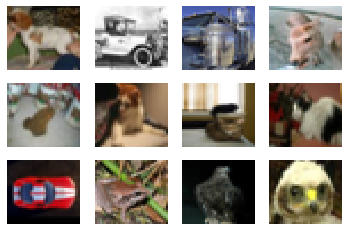

In [7]:
def plot_12_samples(samples,cmap=None):
#     plt.figure(figsize=(6,8))
#     plt.subplots_adjust(left=0,bottom=0,top=1,right=1,wspace=0.1,hspace=0.1)
    for i in range(12):
        plt.subplot(3,4,i+1)
#         plt.imshow(samples[i],vmin=0, vmax=255,cmap="gray",aspect = "auto")
        if cmap is not None:
            plt.imshow(samples[i],vmin=0, vmax=255,cmap=cmap,aspect = "auto")
        else:
            plt.imshow(samples[i],vmin=0, vmax=255,cmap=cmap,aspect = "auto")
        plt.axis("off")
    plt.show()
plot_12_samples(mutated_samples[:12])

In [ ]:
import eagerpy as ep


In [2]:
import sys
sys.path.append("../../ood_2020/empirical_study/")
from attacks.ood_attack import *

import torchvision.transforms as trn
mean = np.array([0.4914, 0.4822, 0.4465]) # cifar10
std = np.array([0.247, 0.2435, 0.2616])
cifar_transforms_test = trn.Compose([trn.ToTensor(), trn.Normalize(mean.tolist(), std.tolist())])

pgd_linf = {"name":"pgd_linf","attack_iter":10,"epsilon":0.3,"eps_step":0.04,
            "clip_min":-2.0,"clip_max":2.5,"targeted":True,"rand_init":False,'mean':mean,'std':std,'type':'adv'} # "clip_min":-2.0,"clip_max":2.5,

pgd_l2 = {"name":"pgd_l2","attack_iter":10,"epsilon":0.3,"eps_step":0.04,
            "clip_min":-2.0,"clip_max":2.5,"targeted":True,"rand_init":False,'mean':mean,'std':std,'type':'adv'}

fgsm = {"name":"fgsm","attack_iter":20,"epsilon":0.5,"eps_step":0.025,
            "clip_min":-2.0,"clip_max":2.5,"targeted":True,'mean':mean,'std':std,'type':'adv'}

i_fgsm = {"name":"i_fgsm","attack_iter":20,"epsilon":0.5,"eps_step":0.025,
            "clip_min":-2.0,"clip_max":2.5,"targeted":True,'mean':mean,'std':std,'type':'adv'}


attack_dic = {
    "pgd_linf":pgd_linf,
    "fgsm":fgsm,
    "i_fgsm":i_fgsm,
}

from utils.ood_loader import OODImages

def make_dataloader(samples,labels,img_size=(32,32), batch_size=256, transform_test=None,shuffle=False):
    ood_dataset = OODImages(samples,labels = labels,img_size = img_size, transform=transform_test)
    ood_loader = torch.utils.data.DataLoader(ood_dataset,batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)
    return ood_loader
model_weights = {
    "resnet18_LLAL":"./cifar10/train/weights/active_resnet18_cifar10_LLAL_1.pth",
    "resnet18_Entropy":"./cifar10/train/weights/active_resnet18_cifar10_Entropy_1.pth",
}

In [6]:
model_name = "resnet18_LLAL"
net = ResNet18(num_classes=10).cuda()
net.load_state_dict(torch.load(model_weights[model_name])['state_dict_backbone'])
net.eval()

attack = "pgd_linf"
_attack_dic = attack_dic[attack]
_attack_dic['type'] = 'adv'

# ood,id -> False ,adv -> True/False
_attack_dic['targeted'] = True#False #True
_attack_dic['epsilon'] = 0.3
_attack_dic['eps_step'] = 0.04 
mean,std = _attack_dic['mean'],_attack_dic['std']


(x_train,y_train),(_,_) = cifar10.load_data()
y_train = y_train.squeeze()
dataloader = make_dataloader(x_train,y_train,
                                        img_size=(32,32), 
                                        batch_size=256,
                                        transform_test=cifar_transforms_test,
                                        shuffle=False)

origs, orig_advs = ood_attack(net,dataloader,_attack_dic)
advs = orig_advs.transpose(0,2,3,1)


>>>Attack Success Rate: 99.36(49678/50000)


In [7]:
from train_utils import test

advs = np.clip(np.uint8((advs*std+mean)*255),0,255)
adv_loader = make_dataloader(advs,None,
                                        img_size=(32,32), 
                                        batch_size=256,
                                        transform_test=cifar_transforms_test,
                                        shuffle=False)

In [8]:
models = {'backbone':net}
dataloaders = {'val':adv_loader}

test(models,dataloaders)
# np.save("adv_samples_LLAL.npy",advs)
# np.save("adv_labels_LLAL.npy",y_train)

(10.29, 97.92, 98.0)

In [ ]:
adv_samples = []
adv_labels = []

In [ ]:
adv_samples = np.load("../deepgini/adv_image/bim_cifar10_image.npy")
labels = np.load("../deepgini/adv_image/bim_cifar10_label.npy")

dataset_train = UserDataset(x_train ,(32,32), labels = y_train, transform = test_transform)
train_loader  = DataLoader(dataset_train, batch_size=batch_num, num_workers=4, pin_memory=True)

In [ ]:
logits, _, _ = net.feature_list(adv_samples)

In [5]:
a = joblib.load(os.path.join(folder,idx_files[0]))
a

defaultdict(None,
            {'epoch_0': defaultdict(None,
                         {'train': [100.0, 99.92, -1],
                          'val': [49.82, 92.07, 82.7],
                          'test': [49.78, 91.78, 83.03]}),
             'epoch_1': defaultdict(None,
                         {'train': [100.0, 99.8, -1],
                          'val': [62.58, 93.53, 80.28],
                          'test': [61.7, 92.96, 80.22]}),
             'epoch_2': defaultdict(None,
                         {'train': [100.0, 99.85, -1],
                          'val': [72.49, 94.78, 80.0],
                          'test': [70.59, 94.05, 79.54]}),
             'epoch_3': defaultdict(None,
                         {'train': [100.0, 99.87, -1],
                          'val': [79.4, 95.85, 79.87],
                          'test': [76.94, 95.08, 79.84]}),
             'epoch_4': defaultdict(None,
                         {'train': [100.0, 99.88, -1],
                          'val': [84.19, 9

In [15]:



def extract_record(cur_dic,dataset,metric): # datasets: train, val, test
    cur_record = []
    for i in range(10):
        cur_epoch = "epoch_{}".format(i)
        cur_record.append(cur_dic[cur_epoch][dataset][metric])
    return cur_record

def extract_all_records(folder,dataset,metric,model_name):
    dic_files = np.sort([item for item in os.listdir(folder) if item.split(".")[-1]=="dic" and item.split("_")[1]==model_name])
    strategies = []
    records = []
    for filename in dic_files:
        cur_file = os.path.join(folder,filename)
        strategies.append(cur_file.split("_")[3])
        cur_dic = joblib.load(cur_file)
        records.append(extract_record(cur_dic,dataset,metric))        
    return strategies,records

folder = "cifar10/train/weights"
dataset = "test"
model_name = "resnet18"
metric  = 2

strategies,records = extract_all_records(folder,dataset,metric,model_name)
df = pd.DataFrame(np.array(records).transpose())
df.columns = strategies
# df.index  = [i for i in range(12)]
df = df.transpose()
df


0      1      2      3      4      5      6      7  \
DSA              83.03  80.22  79.54  79.84  80.07  80.36  80.07  80.32   
Entropy          82.61  82.41  80.92  80.59  80.34  80.02  80.37  80.81   
GINI             83.06  81.43  80.57  79.60  80.13  79.50  79.14  80.80   
LLAL             83.03  83.22  82.49  82.51  82.42  82.17  80.74  81.35   
LSA              82.59  80.45  79.61  79.86  78.30  77.86  79.59  79.25   
LeastConfidence  83.40  81.60  81.27  79.84  79.85  79.33  79.78  79.62   
Margin           82.85  81.96  80.94  80.16  79.56  79.07  79.50  79.46   
Random           82.33  79.82  79.69  78.70  77.63  78.50  78.75  78.76   
XENT             81.98  81.18  81.68  81.03  79.42  79.88  79.98  79.93   

                     8      9  
DSA              80.22  80.97  
Entropy          80.97  81.00  
GINI             80.07  81.22  
LLAL             81.61  81.50  
LSA              78.98  79.85  
LeastConfidence  79.63  80.94  
Margin           79.45  80.60  
Random           79.24  79.34  
XENT             80.06  82.58

<Figure size 720x720 with 0 Axes>

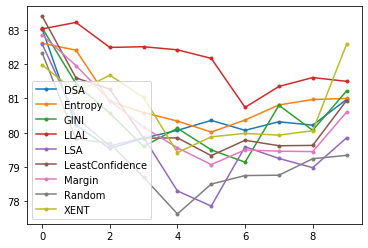

In [16]:
plt.figure(figsize=(10,10))
df.transpose().plot(marker='.')
plt.show()

# Plot

In [24]:
folder = "cifar10/train/retrain"
idx_files = np.sort([item for item in os.listdir(folder) if item.split("_")[-2]=="m" and item.split("_")[1]=="resnet18"])
strategies = np.sort([item.split('_')[3] for item in idx_files])
idx_files,strategies

(array(['active_resnet18_cifar10_DSA_m_idx.npy',
        'active_resnet18_cifar10_Entropy_m_idx.npy',
        'active_resnet18_cifar10_GINI_m_idx.npy',
        'active_resnet18_cifar10_LLAL_m_idx.npy',
        'active_resnet18_cifar10_LSA_m_idx.npy',
        'active_resnet18_cifar10_LeastConfidence_m_idx.npy',
        'active_resnet18_cifar10_Margin_m_idx.npy',
        'active_resnet18_cifar10_Random_m_idx.npy',
        'active_resnet18_cifar10_VRO_m_idx.npy',
        'active_resnet18_cifar10_XENT_m_idx.npy'], dtype='<U49'),
 array(['DSA', 'Entropy', 'GINI', 'LLAL', 'LSA', 'LeastConfidence',
        'Margin', 'Random', 'VRO', 'XENT'], dtype='<U15'))

In [25]:
cal_sim = lambda a,b:len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
heatmap = np.ones((len(strategies),len(strategies)))*100
heatmap

array([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]])

In [26]:
all_sequences = []
for i in range(len(strategies)):
    cur = np.load(os.path.join(folder,idx_files[i]))[:10000]
    all_sequences.append(cur)


    
for i in range(len(strategies)):
    for j in range(i+1,len(strategies)):
        cur_sim = np.round(cal_sim(all_sequences[i],all_sequences[j])*100,2)
        print("Similarity between {} and {}:{}".format(strategies[i],strategies[j],cur_sim))
        heatmap[i][j] = heatmap[j][i] = cur_sim
    

Similarity between DSA and Entropy:10.8
Similarity between DSA and GINI:11.12
Similarity between DSA and LLAL:10.92
Similarity between DSA and LSA:11.18
Similarity between DSA and LeastConfidence:10.96
Similarity between DSA and Margin:11.25
Similarity between DSA and Random:7.2
Similarity between DSA and VRO:11.08
Similarity between DSA and XENT:10.96
Similarity between Entropy and GINI:11.32
Similarity between Entropy and LLAL:10.85
Similarity between Entropy and LSA:11.64
Similarity between Entropy and LeastConfidence:10.96
Similarity between Entropy and Margin:11.09
Similarity between Entropy and Random:7.17
Similarity between Entropy and VRO:11.3
Similarity between Entropy and XENT:11.45
Similarity between GINI and LLAL:11.25
Similarity between GINI and LSA:11.17
Similarity between GINI and LeastConfidence:11.22
Similarity between GINI and Margin:10.84
Similarity between GINI and Random:6.89
Similarity between GINI and VRO:11.55
Similarity between GINI and XENT:11.32
Similarity be

In [27]:
heatmap = pd.DataFrame(heatmap)
heatmap.columns = strategies
heatmap.index = strategies
heatmap

DSA  Entropy    GINI    LLAL     LSA  LeastConfidence  \
DSA              100.00    10.80   11.12   10.92   11.18            10.96   
Entropy           10.80   100.00   11.32   10.85   11.64            10.96   
GINI              11.12    11.32  100.00   11.25   11.17            11.22   
LLAL              10.92    10.85   11.25  100.00   11.78            11.07   
LSA               11.18    11.64   11.17   11.78  100.00            10.91   
LeastConfidence   10.96    10.96   11.22   11.07   10.91           100.00   
Margin            11.25    11.09   10.84   11.61   10.75            11.06   
Random             7.20     7.17    6.89    7.19    6.92             6.88   
VRO               11.08    11.30   11.55   11.22   11.09            11.16   
XENT              10.96    11.45   11.32   10.91   10.92            11.03   

                 Margin  Random     VRO    XENT  
DSA               11.25    7.20   11.08   10.96  
Entropy           11.09    7.17   11.30   11.45  
GINI              10.84    6.89   11.55   11.32  
LLAL              11.61    7.19   11.22   10.91  
LSA               10.75    6.92   11.09   10.92  
LeastConfidence   11.06    6.88   11.16   11.03  
Margin           100.00    6.94   11.10   11.38  
Random             6.94  100.00    7.46    6.88  
VRO               11.10    7.46  100.00   11.17  
XENT              11.38    6.88   11.17  100.00

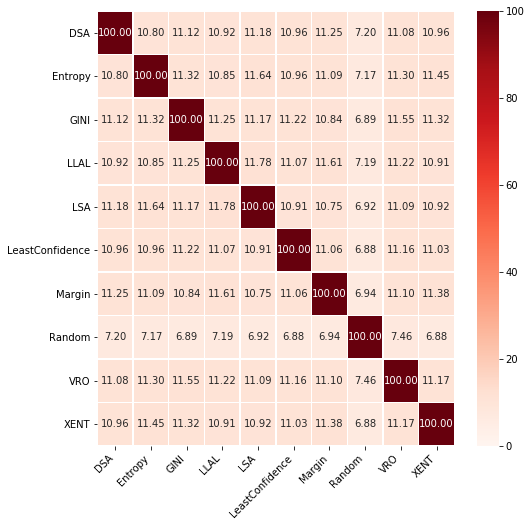

In [28]:
# sns.set_palette(sns.palplot(sns.color_palette("Reds")))
f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(heatmap, annot=True, fmt=".2f",linewidths=0.5,ax=ax,cmap='Reds',vmin=0,vmax=100)
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')

plt.show()

In [42]:
def extract_record(cur_dic,dataset,metric): # datasets: train, val, test
    cur_record = []
    for i in range(12):
        cur_epoch = "epoch_{}".format(i)
        cur_record.append(cur_dic[cur_epoch][dataset][metric])
    return cur_record

def extract_all_records(folder,dataset,metric,model_name):
    dic_files = [item for item in os.listdir(folder) if item.split("_")[-1]=="a.dic" and item.split("_")[1]==model_name]
    strategies = []
    records = []
    for filename in dic_files:
        cur_file = os.path.join(folder,filename)
        strategies.append(cur_file.split("_")[3])
        cur_dic = joblib.load(cur_file)
        records.append(extract_record(cur_dic,dataset,metric))        
    return strategies,records

folder = "cifar10/train/retrain"
dataset = "train"
model_name = "resnet18"
metric  = 0

strategies,records = extract_all_records(folder,dataset,metric,model_name)
df = pd.DataFrame(np.array(records).transpose())
df.columns = strategies
df.index  = [i for i in range(12)]
df

Random  LeastConfidence   GINI  Margin  Entropy    DSA    VRO   XENT  \
0    99.84            99.82  99.86   99.78    99.89  99.89  99.85  99.85   
1    99.85            99.92  99.88   99.89    99.92  99.90  99.91  99.85   
2    99.89            99.87  99.90   99.94    99.95  99.85  99.92  99.88   
3    99.82            99.85  99.78   99.82    99.86  99.88  99.81  99.86   
4    99.88            99.81  99.88   99.83    99.82  99.83  99.86  99.80   
5    99.75            99.79  99.79   99.83    99.87  99.85  99.79  99.80   
6    99.78            99.65  99.78   99.81    99.82  99.83  99.70  99.79   
7    99.66            99.76  99.85   99.79    99.68  99.74  99.70  99.68   
8    99.76            99.74  99.67   99.75    99.75  99.73  99.71  99.76   
9    99.71            99.75  99.66   99.68    99.69  99.55  99.66  99.74   
10   99.58            99.74  99.44   99.60    99.63  99.56  99.56  99.80   
11   98.00            98.52  98.76   98.28    98.68  98.26  98.34  98.18   

      LSA   LLAL  
0   99.90  99.87  
1   99.92  91.19  
2   99.88  91.55  
3   99.89  90.63  
4   99.79  91.49  
5   99.82  91.61  
6   99.76  91.64  
7   99.71  91.56  
8   99.71  90.02  
9   99.75  91.69  
10  99.56  90.26  
11  98.04  90.74

<Figure size 720x720 with 0 Axes>

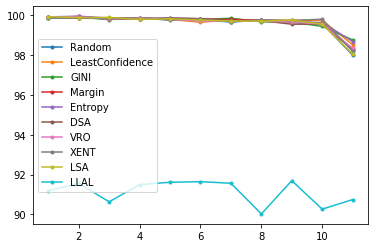

In [43]:
plt.figure(figsize=(10,10))
df[1:].plot(marker='.')
plt.show()

# Surprise

# Add random noise